In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
epi_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling'

In [3]:
infections_cleaned = pd.read_csv(f"{epi_dir}/preprocessed/infections.csv", index_col=0)
infections_cleaned.columns = np.arange(367)

df_screen = pd.read_csv(f"{epi_dir}/preprocessed/screening.csv", index_col=0)
df_screen.columns = np.arange(367)

df_floor = pd.read_csv(f"{epi_dir}/preprocessed/floor_trace.csv", index_col=0)
df_floor.columns = np.arange(367)

df_room = pd.read_csv(f"{epi_dir}/preprocessed/room_trace.csv", index_col=0)
df_room.columns = np.arange(367)

In [4]:
window_starts = [i*7 for i in range(367//7 + 1)]

window_stops = [w -1 for w in window_starts[1:]] + [367]

windows = list(zip(window_starts, window_stops))

In [5]:
infections_rs = pd.DataFrame(index=infections_cleaned.index, columns=np.arange(len(windows)))
for n in infections_cleaned.index:
    for t, w in enumerate(windows):
        a, b = w
        week_data = infections_cleaned.loc[n, a:b]
        if np.isnan(week_data).all():
            infections_rs.loc[n, t] = np.nan
        else:
            infections_rs.loc[n, t] = np.nanmax(week_data)

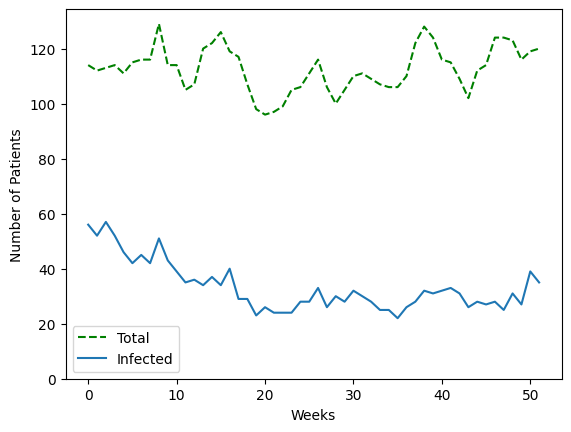

In [6]:
NN = infections_rs.notna().sum(0)[:-1]
II = (infections_rs == 1).sum(0)[:-1]
sns.lineplot(NN, color="green", linestyle="--", label="Total")
sns.lineplot(II, label="Infected")
plt.ylim(bottom=0)
plt.ylabel("Number of Patients")
plt.xlabel("Weeks")
plt.savefig("images/crkp.png")
plt.show()

(0.0, 1.0)

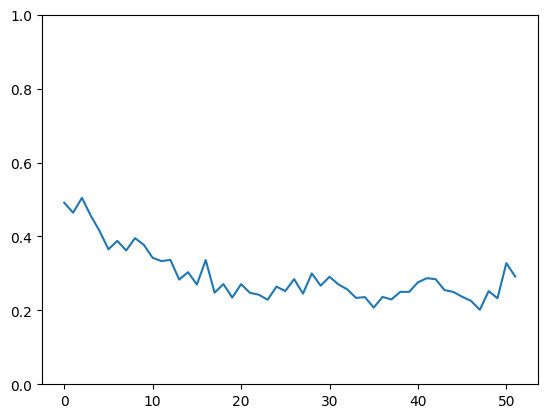

In [7]:
sns.lineplot(II / NN)
plt.ylim(0,1)

In [8]:
df_facility_rs = infections_rs.notna().astype(int)

In [9]:
NN.mean()

112.63461538461539

#### screening data

In [10]:
df_screen_rs = pd.DataFrame(index=infections_cleaned.index, columns=np.arange(len(windows)))
for n in df_screen.index:
    admitted = False
    for t, w in enumerate(windows):
        a, b = w
        week_data = df_screen.loc[n, a:b]
        if not np.isnan(week_data).all():
            df_screen_rs.loc[n, t] = np.nanmax(week_data)
        # if np.isnan(week_data).all():
        #     infections_rs.loc[n, t] = np.nan
        # else:
        #     infections_rs.loc[n, t] = np.nanmax(week_data)

In [11]:
A = df_screen_rs.sum(0)
B = df_screen_rs.notna().sum(0)

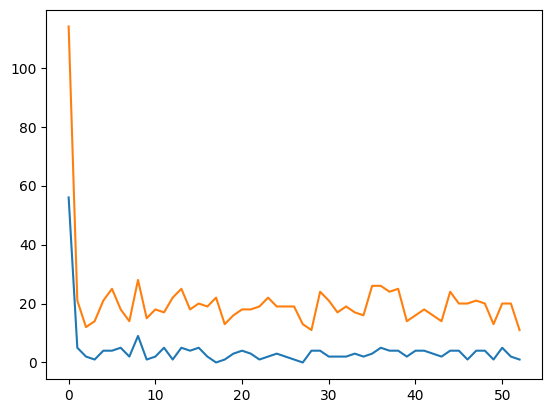

In [12]:
sns.lineplot(A)
sns.lineplot(B)
plt.show()

In [13]:
B[1:].mean()

18.807692307692307

In [14]:
A[1:].mean()

2.9423076923076925

### floor and room trace data

In [15]:
df_floor.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       357, 358, 359, 360, 361, 362, 363, 364, 365, 366],
      dtype='int64', length=367)

In [16]:
df_floor_rs = pd.DataFrame(index=df_floor.index, columns=np.arange(len(windows)))
for n in df_floor.index:
    admitted = False
    for t, w in enumerate(windows):
        a, b = w
        week_data = np.array(df_floor.loc[n, a:b])
        df_floor_rs.loc[n, t] = week_data[np.argmax(week_data > 0)]
        # if not np.isnan(week_data).all():
        #     df_screen_rs.loc[n, t] = np.nanmax(week_data)

In [17]:
df_room_rs = pd.DataFrame(index=df_room.index, columns=np.arange(len(windows)))
for n in df_room.index:
    admitted = False
    for t, w in enumerate(windows):
        a, b = w
        week_data = np.array(df_room.loc[n, a:b])
        df_room_rs.loc[n, t] = week_data[np.argmax(week_data > 0)]

## "observed" data

In [19]:
total_count = infections_rs.sum(0).values

In [20]:
floor_counts = []
X = infections_rs.values
F = df_floor_rs.values
for i in range(1,7):
    # does this work with matrix indexing?
    floor_count = np.nansum(X * (F == i), axis=0)
    floor_counts.append(floor_count)

In [21]:
T = X.shape[1]
room_count = np.zeros(T)
room_count2 = np.zeros(T)
R = df_room_rs.values
r = np.zeros(T).astype(int)
x = np.zeros(T)
w = np.zeros(T)
for t in range(T):
    rx, ry = np.meshgrid(r, r)
    rC = (rx == ry).astype(int)
    I = (x == 1).astype(int)
    infected_roommates = (rC * I).sum(1) 
    room_count[t] = (infected_roommates > 1).sum() / 2
    r = R[:, t]
    x = X[:, t]

In [22]:
observed_data = np.stack([total_count] + floor_counts + [room_count])

In [23]:
observed_data = observed_data.astype(float)

### sanity checks

In [27]:
assert ((df_floor_rs > 0).values == (df_room_rs > 0).values).all()
assert ((infections_rs.notna()).values == (df_facility_rs > 0).values).all()
for n, r in df_screen_rs.iterrows():
    for t, v in r.items():
        if not np.isnan(v):
            assert infections_rs.loc[n, t] == v
            # assert not np.isnan(infections_cleaned.loc[n, t])
assert ((infections_rs.notna()).values == (df_floor_rs > 0).values).all()

#### write out data

In [29]:
# takeaway from sanity check: each week sees about 20 new patients admitted

output_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling/preprocessed/resampled'
infections_rs.to_csv(f"{output_dir}/infections.csv")
df_screen_rs.to_csv(f"{output_dir}/screening.csv")
df_facility_rs.to_csv(f"{output_dir}/facility_trace.csv")
df_floor_rs.to_csv(f"{output_dir}/floor_trace.csv")
df_room_rs.to_csv(f"{output_dir}/room_trace.csv")


In [30]:
with open(f"{output_dir}/observed_data.npy", "wb") as f:
    np.save(f, observed_data)